# Reporte Técnico: Selección e Implementación de Modelos

---

## 1. Introducción

En operaciones de Contugas, monitorear presión, volumen y temperatura es crítico.  
**Pregunta de negocio**: ¿Qué registros representan un comportamiento anómalo?  
Sin etiquetas operativas, definimos anomalía puramente sobre datos históricos, combinando:  
1. **Rolling IQR** per‐cliente → pseudo‐etiquetas univariadas.  
2. **Ensemble** de 3 modelos no supervisados (IF, LOF, OCSVM) → etiquetas finales.  

Los requerimientos R3–R6 (sensibilidad, estabilidad, separación y coherencia) guían este desarrollo.

---

## 2. Propuesta de Modelos

### 2.1 Modelos Considerados

| Modelo                | Ventajas                                     | Desventajas                              |
|-----------------------|----------------------------------------------|------------------------------------------|
| Isolation Forest (IF) | Escalable, genera score, no requiere etiquetas | Sensible a `contamination` y `n_estimators` |
| Local Outlier Factor (LOF) | Detecta anomalías locales                 | Más costoso, necesita `novelty=True`     |
| One-Class SVM (OCSVM) | Flexible (kernels)                           | Lento, sensible a `nu` y `gamma`         |

**Estrategia**: entrenar cada modelo sobre la misma matriz de features,  
recoger labels y scores, luego aplicar un **ensemble** por mayoría (≥2 de 3).

---

## 3. Desarrollo

### 3.1 Instalación de dependencias

```bash
pip install pandas numpy scikit-learn matplotlib seaborn joblib


### 3.1 Lectura y EDA inicial

In [0]:
import pandas as pd
import numpy as np

df = pd.read_excel("/Volumes/sandbox/lab_gob_procibernetica/volumenprueba/datos_clientes.xlsx")
print(df.shape)
df.head()

(847960, 5)


,Fecha,Presion,Temperatura,Volumen,Cliente
0,2019-01-14 00:00:00,17.732563,28.209354,20.969751,CLIENTE1
1,2019-01-14 01:00:00,17.747776,28.518614,17.845739,CLIENTE1
2,2019-01-14 02:00:00,17.758916,28.230191,20.975914,CLIENTE1
3,2019-01-14 03:00:00,17.727940,27.811509,20.592299,CLIENTE1
4,2019-01-14 04:00:00,17.746484,27.795293,21.690626,CLIENTE1


### 3.3 Feature Engineering y Preprocesamiento

In [0]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Asegurar datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values(['Cliente','Fecha']).reset_index(drop=True)

    # 1. Temporales
    df['hour']        = df['Fecha'].dt.hour
    df['day_of_week'] = df['Fecha'].dt.dayofweek
    df['is_weekend']  = (df['day_of_week'] >= 5).astype(int)

    # 2. Cíclicas
    df['sin_hour']        = np.sin(2*np.pi * df['hour']       / 24)
    df['cos_hour']        = np.cos(2*np.pi * df['hour']       / 24)
    df['sin_day_of_week'] = np.sin(2*np.pi * df['day_of_week']/ 7)
    df['cos_day_of_week'] = np.cos(2*np.pi * df['day_of_week']/ 7)

    # 3. Cliente one-hot
    df = pd.get_dummies(df, columns=['Cliente'], prefix='C')

    # 4. Ratios y productos físicos
    df['ratio_pres_vol']  = df['Presion']    / (df['Volumen']    + 1e-6)
    df['ratio_pres_temp'] = df['Presion']    / (df['Temperatura'] + 1e-6)
    df['ratio_vol_temp']  = df['Volumen']    / (df['Temperatura'] + 1e-6)
    df['prod_pres_vol']   = df['Presion'] * df['Volumen']
    df['prod_pres_temp']  = df['Presion'] * df['Temperatura']
    df['prod_vol_temp']   = df['Volumen'] * df['Temperatura']

    # 5. Transformaciones no lineales
    df['log_presion']     = np.log1p(df['Presion'])
    df['log_volumen']     = np.log1p(df['Volumen'])
    df['log_temperatura'] = np.log1p(df['Temperatura'])

    # 6. Estadísticos de la fila
    trio = df[['Presion','Volumen','Temperatura']]
    df['mean_three'] = trio.mean(axis=1)
    df['std_three']  = trio.std(axis=1)
    df['max_three']  = trio.max(axis=1)
    df['min_three']  = trio.min(axis=1)

    # 7. Imputación final
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    return df

def prepare_ml_matrix(df: pd.DataFrame) -> pd.DataFrame:
    drop_cols = ['Fecha']
    return df[[c for c in df.columns if c not in drop_cols]]

# Generar features
df_add = add_features(df)
X  = prepare_ml_matrix(df_add)

print("Matriz de features:", X.shape)
X.head()

/opt/homebrew/Caskroom/miniconda/base/envs/general/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matriz de features: (847960, 43)


,Presion,Temperatura,Volumen,hour,day_of_week,is_weekend,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,...,prod_pres_vol,prod_pres_temp,prod_vol_temp,log_presion,log_volumen,log_temperatura,mean_three,std_three,max_three,min_three
0,17.732563,28.209354,20.969751,0,0,0,0.000000,1.000000,0.0,1.0,...,371.847437,500.224155,591.543116,2.930263,3.089667,3.374489,22.303889,5.364301,28.209354,17.732563
1,17.747776,28.518614,17.845739,1,0,0,0.258819,0.965926,0.0,1.0,...,316.722181,506.141978,508.935750,2.931075,2.936287,3.385021,21.370710,6.190461,28.518614,17.747776
2,17.758916,28.230191,20.975914,2,0,0,0.500000,0.866025,0.0,1.0,...,372.509500,501.337594,592.154045,2.931669,3.089947,3.375202,22.321674,5.363786,28.230191,17.758916
3,17.727940,27.811509,20.592299,3,0,0,0.707107,0.707107,0.0,1.0,...,365.059047,493.040762,572.702903,2.930017,3.072337,3.360775,22.043916,5.196151,27.811509,17.727940
4,17.746484,27.795293,21.690626,4,0,0,0.866025,0.500000,0.0,1.0,...,384.932338,493.268723,602.897309,2.931006,3.121952,3.360212,22.410801,5.062967,27.795293,17.746484


### 3.4 Rolling IQR – Pseudo‐etiquetas

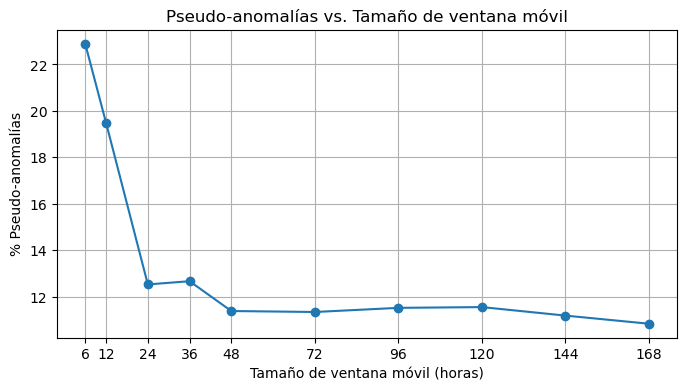

In [0]:
import matplotlib.pyplot as plt

def rolling_iqr_mask(df, variable, window):
    q1 = df.groupby('Cliente')[variable] \
           .transform(lambda x: x.rolling(window,1).quantile(0.25))
    q3 = df.groupby('Cliente')[variable] \
           .transform(lambda x: x.rolling(window,1).quantile(0.75))
    iqr = q3 - q1
    mask = (df[variable] < (q1 - 1.5*iqr)) | (df[variable] > (q3 + 1.5*iqr))
    return mask.astype(int)


# Evaluar distintos tamaños de ventana (en horas)
windows = [6, 12, 24, 36, 48, 72, 96, 120, 144, 168]
percentages = []

for w in windows:
    mask_pres = rolling_iqr_mask(df, 'Presion', w)
    mask_vol  = rolling_iqr_mask(df, 'Volumen', w)
    mask_temp = rolling_iqr_mask(df, 'Temperatura', w)
    pseudo = ((mask_pres + mask_vol + mask_temp) >= 1).astype(int)
    percentages.append(pseudo.mean() * 100)

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(windows, percentages, marker='o', linestyle='-')
plt.xlabel('Tamaño de ventana móvil (horas)')
plt.ylabel('% Pseudo-anomalías')
plt.title('Pseudo-anomalías vs. Tamaño de ventana móvil')
plt.xticks(windows)
plt.grid(True)
plt.show()

In [0]:
# Definir ventana (48 horas = 2 días)
window = 48
mask_pres = rolling_iqr_mask(df,'Presion',window)
mask_vol  = rolling_iqr_mask(df,'Volumen',window)
mask_temp = rolling_iqr_mask(df,'Temperatura',window)

df['pseudo_anom'] = ((mask_pres + mask_vol + mask_temp) >= 1).astype(int)
print("Pseudo‐etiquetas univariadas %anom:", df['pseudo_anom'].mean()*100)

Pseudo‐etiquetas univariadas %anom: 11.378131043917165


### 3.5 Entrenamiento y Calibración de Modelos 

In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, fbeta_score,
                             roc_auc_score, average_precision_score)


def train_and_predict(det_name, X, contamination, random_state=42):
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    if det_name=='if':
        model = IsolationForest(contamination=contamination, random_state=random_state)
    elif det_name=='lof':
        model = LocalOutlierFactor(n_neighbors=20,
                                   contamination=contamination,
                                   novelty=True)
    elif det_name=='ocsvm':
        model = OneClassSVM(nu=contamination, kernel='rbf', gamma='auto')
    else:
        raise ValueError(det_name)
    model.fit(Xs)
    labels = model.predict(Xs)
    scores = model.decision_function(Xs)
    return scaler, model, labels, scores

# Grid search
model_names = ['if', 'lof']
cont_grid = [0.08, 0.10, 0.1138, 0.12, 0.15]
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=2)

metric_names = ['acc', 'prec']

cv_results = []
for name in model_names:
    for c in cont_grid:
        fold_scores = []
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_pseudo_test   = df['pseudo_anom'].iloc[test_idx].values

            # entrenar solo con train
            _, model, _, _ = train_and_predict(name, X_train, contamination=c)
            # predecir sobre test
            scaler = StandardScaler().fit(X_train)
            Xs_test = scaler.transform(X_test)
            y_pred = model.predict(Xs_test)
            y_flag = (y_pred == -1).astype(int)

            # métrica: acuerdo con pseudo-etiquetas en test
            metrics = {
            'acc': (y_flag == y_pseudo_test).mean(),
            'prec': precision_score(y_pseudo_test, y_flag, zero_division=0)
            }
            fold_scores.append(metrics)

        fold_df = pd.DataFrame(fold_scores)
        res     = {'modelo': name, 'contamination': c}
        for m in metric_names:
            res[f'cv_mean_{m}'] = fold_df[m].mean()*100
        cv_results.append(res)

cv_df = pd.DataFrame(cv_results)

metrics_to_show = ['acc', 'prec']


melted = (cv_df
          .melt(id_vars=['contamination', 'modelo'],
                value_vars=[f'cv_mean_{m}' for m in metrics_to_show],
                var_name='metric',
                value_name='valor'))

pivot_multi = (melted
               .pivot_table(index=['contamination', 'metric'],
                            columns='modelo',
                            values='valor')
               .round(2))

display(pivot_multi)  


modelo                         if    lof
contamination metric                    
0.0800        cv_mean_acc   78.87  18.97
              cv_mean_prec  11.18  10.83
0.1000        cv_mean_acc   77.08  18.56
              cv_mean_prec  10.82  10.83
0.1138        cv_mean_acc   75.83  18.31
              cv_mean_prec  10.76  10.82
0.1200        cv_mean_acc   75.32  18.20
              cv_mean_prec  10.78  10.83
0.1500        cv_mean_acc   72.85  17.74
              cv_mean_prec  10.86  10.83

In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, fbeta_score,
                             roc_auc_score, average_precision_score)


def train_and_predict(det_name, X, contamination, random_state=42):
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    if det_name=='if':
        model = IsolationForest(contamination=contamination, random_state=random_state)
    elif det_name=='lof':
        model = LocalOutlierFactor(n_neighbors=20,
                                   contamination=contamination,
                                   novelty=True)
    elif det_name=='ocsvm':
        model = OneClassSVM(nu=contamination, kernel='rbf', gamma='auto')
    else:
        raise ValueError(det_name)
    model.fit(Xs)
    labels = model.predict(Xs)
    scores = model.decision_function(Xs)
    return scaler, model, labels, scores

# Grid search
model_names = ['if', 'lof']
cont_grid = [0.005, 0.02, 0.05, 0.08, 0.10, 0.1138, 0.12, 0.15]
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=2)

metric_names = ['acc', 'prec']

cv_results = []
for name in model_names:
    for c in cont_grid:
        fold_scores = []
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_pseudo_test   = df['pseudo_anom'].iloc[test_idx].values

            # entrenar solo con train
            _, model, _, _ = train_and_predict(name, X_train, contamination=c)
            # predecir sobre test
            scaler = StandardScaler().fit(X_train)
            Xs_test = scaler.transform(X_test)
            y_pred = model.predict(Xs_test)
            y_flag = (y_pred == -1).astype(int)

            # métrica: acuerdo con pseudo-etiquetas en test
            metrics = {
            'acc': (y_flag == y_pseudo_test).mean(),
            'prec': precision_score(y_pseudo_test, y_flag, zero_division=0)
            }
            fold_scores.append(metrics)

        fold_df = pd.DataFrame(fold_scores)
        res     = {'modelo': name, 'contamination': c}
        for m in metric_names:
            res[f'cv_mean_{m}'] = fold_df[m].mean()*100
        cv_results.append(res)

cv_df = pd.DataFrame(cv_results)

metrics_to_show = ['acc', 'prec']


melted = (cv_df
          .melt(id_vars=['contamination', 'modelo'],
                value_vars=[f'cv_mean_{m}' for m in metrics_to_show],
                var_name='metric',
                value_name='valor'))

pivot_multi = (melted
               .pivot_table(index=['contamination', 'metric'],
                            columns='modelo',
                            values='valor')
               .round(2))

display(pivot_multi)  

modelo                         if    lof
contamination metric                    
0.0050        cv_mean_acc   88.07  16.68
              cv_mean_prec  11.19  11.59
0.0200        cv_mean_acc   79.64  16.09
              cv_mean_prec  10.64  11.53
0.0500        cv_mean_acc   76.44  15.60
              cv_mean_prec  10.28  11.49
0.0800        cv_mean_acc   74.28  15.24
              cv_mean_prec  10.06  11.46
0.1000        cv_mean_acc   72.99  15.02
              cv_mean_prec   9.96  11.44
0.1138        cv_mean_acc   72.20  14.89
              cv_mean_prec  10.02  11.43
0.1200        cv_mean_acc   71.83  14.82
              cv_mean_prec   9.99  11.43
0.1500        cv_mean_acc   69.99  14.55
              cv_mean_prec  10.09  11.40

In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, fbeta_score,
                             roc_auc_score, average_precision_score)


def train_and_predict(det_name, X, contamination, random_state=42):
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    if det_name=='if':
        model = IsolationForest(contamination=contamination, random_state=random_state)
    elif det_name=='lof':
        model = LocalOutlierFactor(n_neighbors=20,
                                   contamination=contamination,
                                   novelty=True)
    elif det_name=='ocsvm':
        model = OneClassSVM(nu=contamination, kernel='rbf', gamma='auto')
    else:
        raise ValueError(det_name)
    model.fit(Xs)
    labels = model.predict(Xs)
    scores = model.decision_function(Xs)
    return scaler, model, labels, scores

# Grid search
model_names = ['if', 'lof']
cont_grid = [0.005, 0.02, 0.05, 0.08, 0.10, 0.1138, 0.12, 0.15]
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

metric_names = ['acc', 'prec']

cv_results = []
for name in model_names:
    for c in cont_grid:
        fold_scores = []
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_pseudo_test   = df['pseudo_anom'].iloc[test_idx].values

            # entrenar solo con train
            _, model, _, _ = train_and_predict(name, X_train, contamination=c)
            # predecir sobre test
            scaler = StandardScaler().fit(X_train)
            Xs_test = scaler.transform(X_test)
            y_pred = model.predict(Xs_test)
            y_flag = (y_pred == -1).astype(int)

            # métrica: acuerdo con pseudo-etiquetas en test
            metrics = {
            'acc': (y_flag == y_pseudo_test).mean(),
            'prec': precision_score(y_pseudo_test, y_flag, zero_division=0)
            }
            fold_scores.append(metrics)

        fold_df = pd.DataFrame(fold_scores)
        res     = {'modelo': name, 'contamination': c}
        for m in metric_names:
            res[f'cv_mean_{m}'] = fold_df[m].mean()*100
        cv_results.append(res)

cv_df = pd.DataFrame(cv_results)

metrics_to_show = ['acc', 'prec']


melted = (cv_df
          .melt(id_vars=['contamination', 'modelo'],
                value_vars=[f'cv_mean_{m}' for m in metrics_to_show],
                var_name='metric',
                value_name='valor'))

pivot_multi = (melted
               .pivot_table(index=['contamination', 'metric'],
                            columns='modelo',
                            values='valor')
               .round(2))

display(pivot_multi)  

modelo                         if    lof
contamination metric                    
0.0050        cv_mean_acc   88.48  22.28
              cv_mean_prec   6.41  10.83
0.0200        cv_mean_acc   83.76  20.82
              cv_mean_prec  11.12  10.82
0.0500        cv_mean_acc   81.12  19.69
              cv_mean_prec  11.54  10.83
0.0800        cv_mean_acc   78.87  18.97
              cv_mean_prec  11.18  10.83
0.1000        cv_mean_acc   77.08  18.56
              cv_mean_prec  10.82  10.83
0.1138        cv_mean_acc   75.83  18.31
              cv_mean_prec  10.76  10.82
0.1200        cv_mean_acc   75.32  18.20
              cv_mean_prec  10.78  10.83
0.1500        cv_mean_acc   72.85  17.74
              cv_mean_prec  10.86  10.83

In [0]:
# ───────────────────────────────────────────────────────────────────────────────
# 0. DEPENDENCIES ───────────────────────────────────────────────────────────────
# Ejecuta la línea pip sólo una vez en un entorno limpio
# !pip install scipy==1.12.0

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, zscore
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

RANDOM_STATE = 42
# df = pd.read_csv("tu_archivo.csv")  #  ←  carga aquí tu dataset original
# ───────────────────────────────────────────────────────────────────────────────
# 1. FEATURE ENGINEERING ───────────────────────────────────────────────────────
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values(['Cliente', 'Fecha']).reset_index(drop=True)

    # 1. Temporales básicas
    df['hour']        = df['Fecha'].dt.hour
    df['day_of_week'] = df['Fecha'].dt.dayofweek
    df['is_weekend']  = (df['day_of_week'] >= 5).astype(int)

    # 2. Señales cíclicas
    df['sin_hour']        = np.sin(2*np.pi * df['hour']        / 24)
    df['cos_hour']        = np.cos(2*np.pi * df['hour']        / 24)
    df['sin_day_of_week'] = np.sin(2*np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2*np.pi * df['day_of_week'] / 7)

    # 3. One‑hot por cliente
    df = pd.get_dummies(df, columns=['Cliente'], prefix='C')

    # 4. Ratios y productos
    df['ratio_pres_vol']  = df['Presion']     / (df['Volumen']     + 1e-6)
    df['ratio_pres_temp'] = df['Presion']     / (df['Temperatura'] + 1e-6)
    df['ratio_vol_temp']  = df['Volumen']     / (df['Temperatura'] + 1e-6)
    df['prod_pres_vol']   = df['Presion'] * df['Volumen']
    df['prod_pres_temp']  = df['Presion'] * df['Temperatura']
    df['prod_vol_temp']   = df['Volumen'] * df['Temperatura']

    # 5. Transformaciones log‑safe
    df['log_presion']     = np.log1p(df['Presion'])
    df['log_volumen']     = np.log1p(df['Volumen'])
    df['log_temperatura'] = np.log1p(df['Temperatura'])

    # 6. Estadísticos fila
    trio = df[['Presion', 'Volumen', 'Temperatura']]
    df['mean_three'] = trio.mean(axis=1)
    df['std_three']  = trio.std(axis=1)
    df['max_three']  = trio.max(axis=1)
    df['min_three']  = trio.min(axis=1)

    # 7. Imputación medianas
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    return df

def prepare_ml_matrix(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns=['Fecha'])
# ───────────────────────────────────────────────────────────────────────────────
# 2. PSEUDO‑LABEL 2.0 (ROLLING IQR 48 h) ───────────────────────────────────────
def rolling_iqr_mask(df, variable, window):
    q1 = df.groupby('Cliente')[variable].transform(
             lambda x: x.rolling(window, 1).quantile(0.25))
    q3 = df.groupby('Cliente')[variable].transform(
             lambda x: x.rolling(window, 1).quantile(0.75))
    iqr = q3 - q1
    return ((df[variable] < (q1 - 1.5*iqr)) |
            (df[variable] > (q3 + 1.5*iqr))).astype(int)

def make_pseudo_label(df, window=48):
    m_p = rolling_iqr_mask(df, 'Presion',     window)
    m_v = rolling_iqr_mask(df, 'Volumen',     window)
    m_t = rolling_iqr_mask(df, 'Temperatura', window)
    return ((m_p + m_v + m_t) >= 1).replace({1: -1, 0: 1}).to_numpy()
# ───────────────────────────────────────────────────────────────────────────────
# 3. METRICAS NO SUPERVISADAS ──────────────────────────────────────────────────
def gap_score(scores, preds):
    normals = scores[preds == 1]
    anoms   = scores[preds == -1]
    iqr = np.subtract(*np.percentile(scores, [75, 25]))
    return np.abs(np.median(normals) - np.median(anoms)) / (iqr + 1e-9)

def bimodality_coefficient(scores):
    n = len(scores)
    g = skew(scores)
    k = kurtosis(scores, fisher=False)
    return (g**2 + 1) / (k + (3*((n-1)**2)/((n-2)*(n-3))))

def extreme_coverage(df_cont, preds, z_thresh=2):
    z = zscore(df_cont, nan_policy="omit")
    is_extreme = (np.abs(z) > z_thresh).any(axis=1)
    return is_extreme[preds == -1].mean()

def metrics_block_unsup(preds, scores, cont_df_val):
    """Devuelve SOLO las métricas no supervisadas para el fold de CV."""
    gap = gap_score(scores, preds)
    bc  = bimodality_coefficient(scores)
    ext = extreme_coverage(cont_df_val.values, preds)
    return gap, bc, ext


# ───────────────────────────────────────────────────────────────────────────────
# 4. TRAIN & EVAL ───────────────────────────────────────────────────────────────
def fit_predict(det_name, X_train, X_val, contamination, n_neighbors=None):
    """
    Entrena y predice con IsolationForest o LocalOutlierFactor,
    permitiendo ajustar n_neighbors para LOF.
    
    Parameters:
    - det_name: "if" o "lof"
    - X_train, X_val: matrices de features (numpy o pandas)
    - contamination: float, porcentaje estimado de anomalías
    - n_neighbors: int o None; solo se usa si det_name=="lof"
    
    Returns:
    - preds_val: array de predicciones (1 normal, -1 anomalía)
    - scores_val: array de decision_function (scores)
    """
    scaler = StandardScaler().fit(X_train)
    Xtr, Xvl = scaler.transform(X_train), scaler.transform(X_val)

    if det_name == "if":
        model = IsolationForest(
            contamination=contamination,
            random_state=RANDOM_STATE
        )
    elif det_name == "lof":
        # usar el valor de n_neighbors provisto (por defecto 20)
        k = n_neighbors if n_neighbors is not None else 20
        model = LocalOutlierFactor(
            n_neighbors=k,
            contamination=contamination,
            novelty=True
        )
    else:
        raise ValueError(f"Detector desconocido: {det_name}")

    model.fit(Xtr)
    preds_val  = model.predict(Xvl)
    scores_val = model.decision_function(Xvl)
    return preds_val, scores_val

# ───────────────────────────────────────────────────────────────────────────────
# 5. PIPELINE CON VALIDACIÓN CRUZADA TEMPORAL ──────────────────────────────────
df_fe  = add_features(df)
X_full = prepare_ml_matrix(df_fe)
cont_df = df_fe[['Presion', 'Volumen', 'Temperatura']]
y_pseudo = make_pseudo_label(df, window=48)

tscv = TimeSeriesSplit(n_splits=3)  # expanding‑window CV

# ─────────  Parámetros de grid  ─────────
contamination_grid = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
neighbors_grid    = [5, 10, 20]  # ejemplo: prueba estos valores en LOF

# ─────────  Cross-validation (solo no supervisadas)  ─────────
cv_results = []
for det in ["if", "lof"]:
    for c in contamination_grid:
        for n in (neighbors_grid if det=="lof" else [None]):
            gaps, bcs, exts, rates = [], [], [], []
            for train_idx, val_idx in tscv.split(X_full):
                # pasar el parámetro n_neighbors a fit_predict
                preds, scores = fit_predict(det,
                                            X_full.iloc[train_idx],
                                            X_full.iloc[val_idx],
                                            c,
                                            n_neighbors=n)

                gap, bc, ext = metrics_block_unsup(
                                   preds, scores,
                                   cont_df.iloc[val_idx])

                gaps.append(gap);  bcs.append(bc); exts.append(ext)
                rates.append((preds == -1).mean())

            cv_results.append({
                "detector":       det,
                "contamination":  c,
                "n_neighbors":    n,
                "gap_cv":         np.mean(gaps),
                "bimodality_cv":  np.mean(bcs),
                "ext_cov_cv":     np.mean(exts),
                "anomaly_rate":   np.mean(rates)
            })

df_cv = pd.DataFrame(cv_results).round(3)
display(df_cv.sort_values(
    ["detector","gap_cv"], ascending=[True, False]))

# ─────────  Supervisadas globales  ─────────
sup_results = []
for det in ["if", "lof"]:
    for c in contamination_grid:
        for n in (neighbors_grid if det=="lof" else [None]):
            scaler = StandardScaler().fit(X_full)
            Xs = scaler.transform(X_full)

            if det == "if":
                mdl = IsolationForest(contamination=c, random_state=RANDOM_STATE)
            else:
                mdl = LocalOutlierFactor(
                    n_neighbors=n,
                    contamination=c,
                    novelty=True)

            mdl.fit(Xs)
            preds = mdl.predict(Xs)
            y_bin = (y_pseudo == -1).astype(int)
            p_bin = (preds    == -1).astype(int)

            sup_results.append({
                "detector":       det,
                "contamination":  c,
                "n_neighbors":    n,
                "accuracy":       accuracy_score(y_bin, p_bin),
                "precision":      precision_score(y_bin, p_bin, zero_division=0),
                "recall":         recall_score(y_bin,  p_bin, zero_division=0),
                "f1_score":       f1_score(y_bin,     p_bin, zero_division=0),
                "anomaly_rate":   p_bin.mean()
            })

df_sup = pd.DataFrame(sup_results).round(3)
display(df_sup.sort_values(
    ["detector","f1_score"], ascending=[True, False]))



/opt/homebrew/Caskroom/miniconda/base/envs/general/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,detector,contamination,n_neighbors,gap_cv,bimodality_cv,ext_cov_cv,anomaly_rate
0,if,0.025,NaN,1.694,0.247,0.801,0.062
1,if,0.050,NaN,1.586,0.247,0.696,0.084
2,if,0.075,NaN,1.531,0.247,0.640,0.106
3,if,0.100,NaN,1.487,0.247,0.596,0.131
4,if,0.125,NaN,1.449,0.247,0.558,0.157
5,if,0.150,NaN,1.408,0.247,0.527,0.184
7,lof,0.025,10.0,1.045,0.348,0.161,0.928
10,lof,0.050,10.0,1.041,0.348,0.160,0.939
13,lof,0.075,10.0,1.039,0.348,0.160,0.944
16,lof,0.100,10.0,1.037,0.348,0.159,0.948


In [0]:
df_sup.to_excel('resultado_modelos.xlsx')